# Naročanje knjig preko spleta

Spletna stran [Book Depository](https://www.bookdepository.com/) nudi brezplačno pošiljanje knjig po celem svetu. Ali imajo morda zato dražje cene knjig kot drugi ponudniki, in tako ceno poštnine "skrijejo" v ceno knjige? Na to vprašanje sem poskušala odgovoriti v tem projektu. Zbrala sem podatke še iz druge popularne spletne strani za naročanje knjig - [Amazon](https://www.amazon.com/). Vse podatke primerne za primerjavo sem zbrala v dveh tabelah.

In [1]:
import pandas as pd
depository = pd.read_csv('csv-datoteke/depositoryVSI.csv')
amazon = pd.read_csv('csv-datoteke/amazonVSI.csv')
%matplotlib inline

## Urejanje podatkov
Zajela sem podatke dveh različnih spletnih strani, zato ni nenavadno da so v različnih formatih. Da jih bom lažje primerjala, jih je najprej potrebno urediti.

In [2]:
#Da bo mogoče računanje s cenami iz Book Depository-ja je potrebno nize spremeniti v številke in vejico v piko
def popraviVejco(niz): 
    nova=niz[:-3]+'.'+niz[-2:]
    return float(nova)
depository['cenaE']=depository['cenaE'].map(popraviVejco)

#Shranjevanje ISBN kod kot števila je povzročilo, da so se odstranile vse začetne ničle
def popraviISBN10(stevilka):
    stevilka=str(stevilka)
    dolzina=len(stevilka)
    if dolzina<10:
        return '0'*(10-dolzina)+stevilka
    else:
        return stevilka
depository['ISBN10']=depository['ISBN10'].map(popraviISBN10)
amazon['ISBN10']=amazon['ISBN10'].map(popraviISBN10)

def popraviISBN13(stevilka):
    stevilka=str(stevilka)
    dolzina=len(stevilka)
    if dolzina<13:
        return '0'*(10-dolzina)+stevilka
    else:
        return stevilka
depository['ISBN13']=depository['ISBN13'].map(popraviISBN13)

#Cene na Amazonu so podane v dolarjih in jih je za primerjavo potrebno pretvoriti v evre
def pretvoriEuro(cena):
    nova=round(cena*0.893295815,2)
    return nova
amazon['cenaD']=amazon['cenaD'].map(pretvoriEuro)

#Iz datuma sem izluščila posamezna leta
def leto(date):
    return int(date[-4:])
depository['leto']=depository['datum'].map(leto)

Vsi podatki so zbrani v tabeli **knjige**, cene so zapisane v evrih.

In [3]:
knjige = pd\
    .merge(depository, amazon)\
    .set_index('ISBN10')
knjige\
    .rename(columns={'cenaE':'Depository', 'cenaD':'Amazon'}, inplace=True)
knjige[:5]

,avtor,naslov,Depository,format,jezik,datum,ISBN13,leto,Amazon
ISBN10,,,,,,,,,
0062300547,J D Vance,Hillbilly Elegy : A Memoir of a Family and Cul...,22.80,Hardback,English,28 Jun 2016,9780062300546,2016,15.00
0062315005,Paulo Coelho,The Alchemist,12.20,Paperback,English,01 May 2014,9780062315007,2014,9.10
0071771328,Kerry Patterson,Crucial Conversations Tools for Talking When S...,12.96,Paperback,English,01 Oct 2011,9780071771320,2011,10.09
0073523917,Stephen E. Lucas,The Art of Public Speaking,156.74,Paperback,English,01 Nov 2014,9780073523910,2014,88.18
0077733711,Jane P. Mallor,Business Law,316.81,Hardback,English,01 Mar 2015,9780077733711,2015,294.95


## Ali so knjige na Amazonu res cenejše?
Oglejmo si graf, na katerem so prikazane cene za oba spletna ponudnika. Opazimo, da sta si običajno obe ceni za določeno knjigo zelo podobni, vendar pa iz grafa lahko vidimo, da so cene na Book Depository-ju višje.

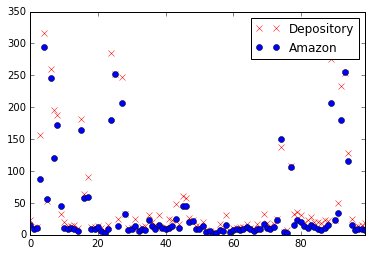

In [4]:
knjige.reset_index()[:100].plot(y=['Depository','Amazon'], style=['rx','o'])

Poglejmo si, kakšen procent knjig je dejansko cenejši na spletni strani Amazon.


In [5]:
(knjige[knjige.Depository>knjige.Amazon]['ISBN13'].size)/(knjige['ISBN13'].size)

0.9526813880126183

Izkaže se, da je kar **95,3%** knjig cenejših na Amazonu. Ali pa je razlika dovolj velika, da pokrije tudi poštnino? Poglejmo si razlike v cenah.

In [6]:
knjige['razlika']=knjige['Depository']-knjige['Amazon']
knjige[['Depository','Amazon','razlika']][:5]

,Depository,Amazon,razlika
ISBN10,,,
0062300547,22.80,15.00,7.80
0062315005,12.20,9.10,3.10
0071771328,12.96,10.09,2.87
0073523917,156.74,88.18,68.56
0077733711,316.81,294.95,21.86


In [7]:
knjige['razlika'].mean()

7.453880126182962

V povprečju so knjige za kar 7.45  € cenejše na Amazonu. Običajna poštnina za eno "navadno težko" knjigo je 7.13€, za dve pa 10.69€. 
Če naročimo za več kot 22.33 € knjig je poštnina pogosto celo brezplačna. Glede na izračune se zdi, da če naročamo samo eno knjigo so cene zelo podobne, če pa jih naročamo več, se nam bolj splača Amazon.
Kdaj pa se nam splača naročiti samo eno knjigo preko Depository-a namesto Amazona? Oglejmo si graf, kako se spreminjajo razlike z večanjem cen (na recimo Book Depository-ju). Rdeča črta predstavlja ceno poštnine posamezne knjige, ki stane manj kot 22.33 € (nad 22.33 € poštnine ni).

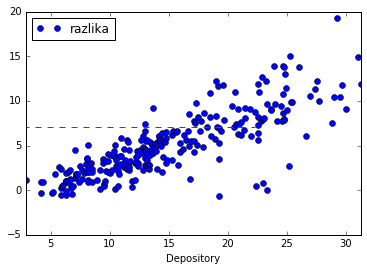

In [8]:
knjige\
    .reset_index()\
    .sort_values(by='Depository',ascending=True)[:270]\
    .plot(x='Depository',y='razlika',style='o')\
    .plot([0,22.33],[7.13,7.13],'r--')

Opazimo, da so za knjige cenejše od približno 20 € celo razlike manjše od poštnine za posamezno knjigo. Oglejmo si povprečne razlike za knjige cenejše od 10 €, med 10 - 20 €, med 20 - 30 €...

In [9]:
knjige['DepositoryMed']=knjige['Depository']//10*10
knjige\
    .groupby('DepositoryMed')[['razlika']]\
    .mean()[:60]

,razlika
DepositoryMed,
0.0,1.604923
10.0,4.772929
20.0,9.053492
30.0,10.920588
40.0,16.163333
50.0,3.290000
60.0,21.573333


Torej, če naročamo **posamezno** knjigo **cenejšo od 20€ **, se nam jo bolj izplača naročiti preko Book Depository-ja. Za dražje knjige pa se pogosteje bolj izplača Amazon.

## Ali vezava knjige kaj vpliva na razlike v cenah?
Knjige lahko kupimo v različnih formatih. Najbolj običajni sta mehka (Paperback) in trda (Hardback) vezava. Vrsta vezave zagotovo vpliva na težo knjige. Ali zato vpliva tudi na razlike v cenah?

In [10]:
knjige[(knjige['format']=='Hardback')|(knjige['format']=='Paperback')]\
    .groupby('format')[['razlika']]\
    .mean()

,razlika
format,
Hardback,11.022222
Paperback,5.943622


Iz zbranih podatkov lahko vidimo, da so razlike znatno manjše, če naročamo knjigo z mehko vezavo (Paperback), kot če naročamo knjigo s trdo vezavo (Hardback). Izgleda, da se nam knjige z mehko vezavo celo bolj izplača kupovati preko Book Depository-a, s trdo pa preko Amazona.

## Ali leto izdaje kaj vpliva na razlike v cenah?

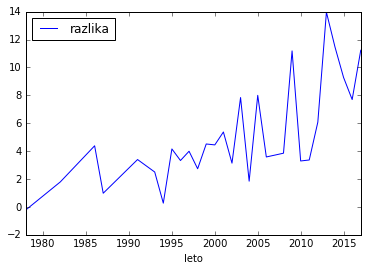

In [11]:
knjige[(knjige['leto']>1970)]\
    .groupby('leto')[['razlika']]\
    .mean()\
    .plot()

Iz grafa je razvidno, da se trend razlik z leti povečuje. Iz zbranih podatkov težko povemo kaj o posameznih letih, lahko pa opazimo, da imajo novejše knjige veliko bolj ugodne cene na Amazon-u.